### 1. Problem Definition

For this work, we will build a model to predict the depth of to ground water of an aquifer located in Petrignano, Italy. We will predict the predict the future depth to groundwater of a well belonging to the aquifier in Petrigrano over the next quarter?

The wells field of the alluvial plain of Petrignano is fed by three underground aquifiers separated by low permeability septa. The groundwater levels are influenced by the following parameters: rainfall, depth of groundwater, temperatures and drainage volumes, level of the Chiascio river.

Indeed, both rainfall and temperatue affect features like level, flow, depth to groundwater and hydrometry some time after it fell down.

### 2. Data Collection and Importing Libraries

In [1]:
# Importing libraries
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import mean_absolute_error, mean_squared_error
import math

import warnings # Supress warnings
warnings.filterwarnings('ignore')

In [2]:
# Loading the Dataset
df = pd.read_csv(r'C:\Users\hp\Desktop\Aquifer_Petrignano.csv')

### Simplifications
df = df[df.Rainfall_Bastia_Umbra.notna()].reset_index(drop=True)
df = df.drop(['Depth_to_Groundwater_P24', 'Temperature_Petrignano'], axis = 1)

# Simplify column names
df.columns = ['Date', 'Rainfall', 'Depth_to_Groundwater', 'Temperature', 'Drainage_Volume', 'River_Hydrometry']

# Target Variable
targets = ['Depth_to_Groundwater']
features = [feature for feature in df.columns if feature not in targets]

df.head()

,Date,Rainfall,Depth_to_Groundwater,Temperature,Drainage_Volume,River_Hydrometry
0,01/01/2009,0.0,-31.14,5.2,-24530.688,2.4
1,02/01/2009,0.0,-31.11,2.3,-28785.888,2.5
2,03/01/2009,0.0,-31.07,4.4,-25766.208,2.4
3,04/01/2009,0.0,-31.05,0.8,-27919.296,2.4
4,05/01/2009,0.0,-31.01,-1.9,-29854.656,2.3


In [3]:
# Convert Date to datetime
from datetime import datetime, date 

df['Date'] = pd.to_datetime(df.Date, format = '%d/%m/%Y')
df.head().style.set_properties(subset=['Date'], **{'background-color': 'dodgerblue'})

,Date,Rainfall,Depth_to_Groundwater,Temperature,Drainage_Volume,River_Hydrometry
0,2009-01-01 00:00:00,0.000000,-31.140000,5.200000,-24530.688000,2.400000
1,2009-01-02 00:00:00,0.000000,-31.110000,2.300000,-28785.888000,2.500000
2,2009-01-03 00:00:00,0.000000,-31.070000,4.400000,-25766.208000,2.400000
3,2009-01-04 00:00:00,0.000000,-31.050000,0.800000,-27919.296000,2.400000
4,2009-01-05 00:00:00,0.000000,-31.010000,-1.900000,-29854.656000,2.300000


Features:
- **Rainfall** indicates the quantity of rain falling (mm)
- **Temperature** indicates the temperature (°C)
- **Volume** indicates the volume of water taken from the drinking water treatment plant (m3)
- **Hydrometry** indicates the groundwater level (m)

Target:
- **Depth to Groundwater** indicates the groundwater level (m from the ground floor)

Text(0, 0.5, 'Depth to Groundwater')

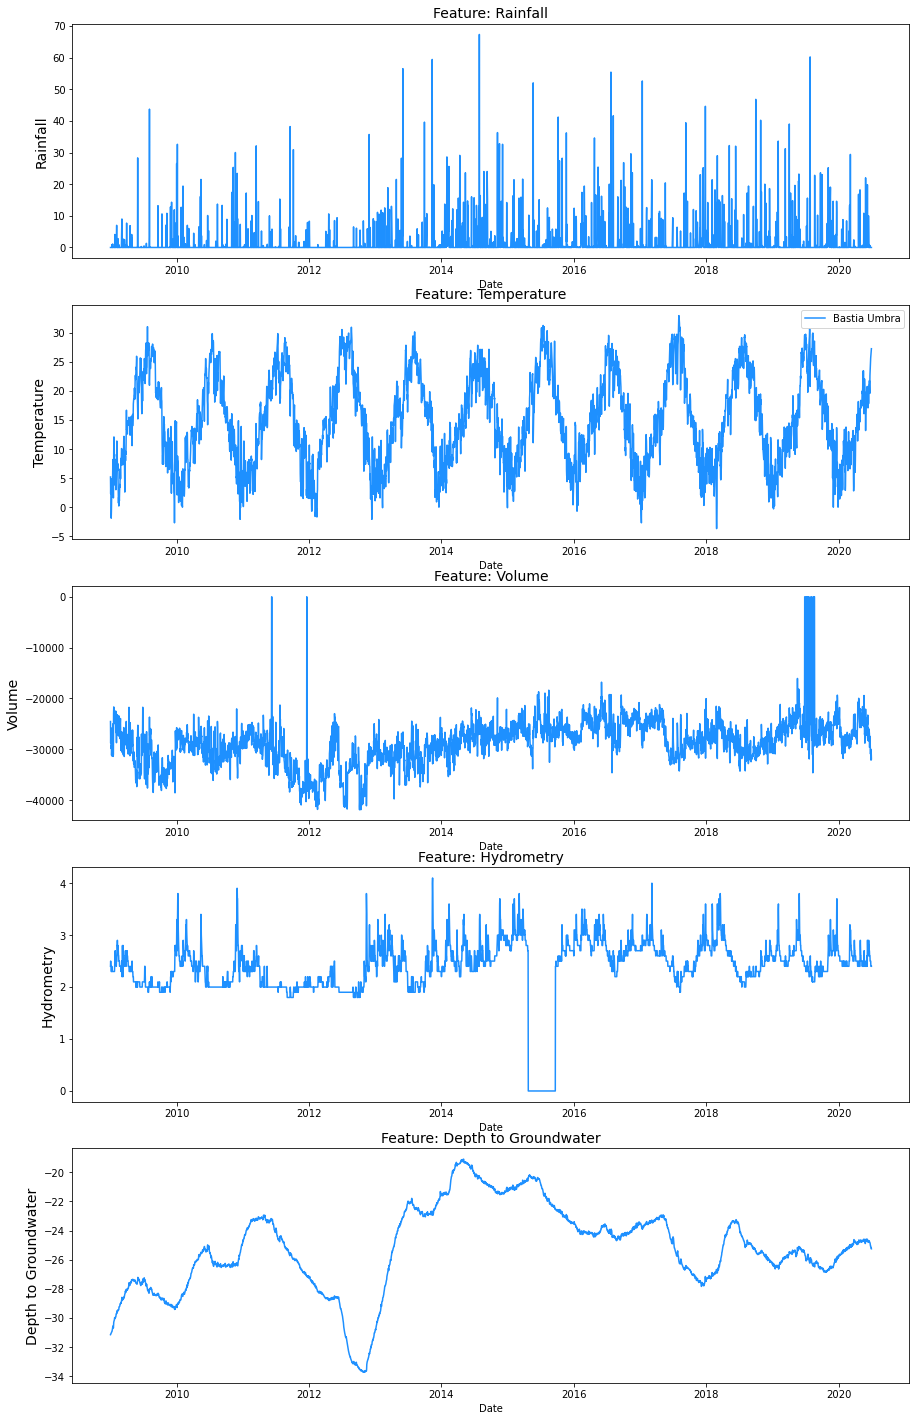

In [4]:
f, ax = plt.subplots(nrows=5, ncols=1, figsize=(15, 25))

sns.lineplot(x=df.Date, y=df.Rainfall.fillna(np.inf), ax=ax[0], color='dodgerblue')
ax[0].set_title('Feature: Rainfall', fontsize=14)
ax[0].set_ylabel(ylabel='Rainfall', fontsize=14)

sns.lineplot(x=df.Date, y=df.Temperature.fillna(np.inf), ax=ax[1], color='dodgerblue', label='Bastia Umbra')
ax[1].set_title('Feature: Temperature', fontsize=14)
ax[1].set_ylabel(ylabel='Temperature', fontsize=14)

sns.lineplot(x=df.Date, y=df.Drainage_Volume.fillna(np.inf), ax=ax[2], color='dodgerblue')
ax[2].set_title('Feature: Volume', fontsize=14)
ax[2].set_ylabel(ylabel='Volume', fontsize=14)

sns.lineplot(x=df.Date, y=df.River_Hydrometry.fillna(np.inf), ax=ax[3], color='dodgerblue')
ax[3].set_title('Feature: Hydrometry', fontsize=14)
ax[3].set_ylabel(ylabel='Hydrometry', fontsize=14)

sns.lineplot(x=df.Date, y=df.Depth_to_Groundwater.fillna(np.inf), ax=ax[4], color='dodgerblue')
ax[4].set_title('Feature: Depth to Groundwater', fontsize=14)
ax[4].set_ylabel(ylabel='Depth to Groundwater', fontsize=14)

### 3. Data Preprocessing

### Chronological Order and Equidistant Timestamps

Since our data is already in chronological order and the time interval is one day, we do not have to do the data preparation regarding the chronological order and equidistant timestamps. Equidistant timestamps indicates constant time intervals. If this is not the case, we can decide on a constant time interval and resample the data.

In [5]:
# Sort values by timestamp (not necessary in this case)
# df = df.sort_values(by='Date')

# Check time intervals
df['Time_Interval'] = df.Date - df.Date.shift(1)
df[['Date', 'Time_Interval']].head()

,Date,Time_Interval
0,2009-01-01,NaT
1,2009-01-02,1 days
2,2009-01-03,1 days
3,2009-01-04,1 days
4,2009-01-05,1 days


In [6]:
print(f"{df['Time_Interval'].value_counts()}")
df = df.drop('Time_Interval', axis=1)

1 days    4198
Name: Time_Interval, dtype: int64


### Handling Missing Values

We can see that Depth_to_Groundwater has missing values.
Furthermore, plotting the time series reveals that there seem to be some impausible zero values for Drainage_Volume, and River_Hydrometry. We will have to clean them by replacing them by nan values and filling them afterwards.

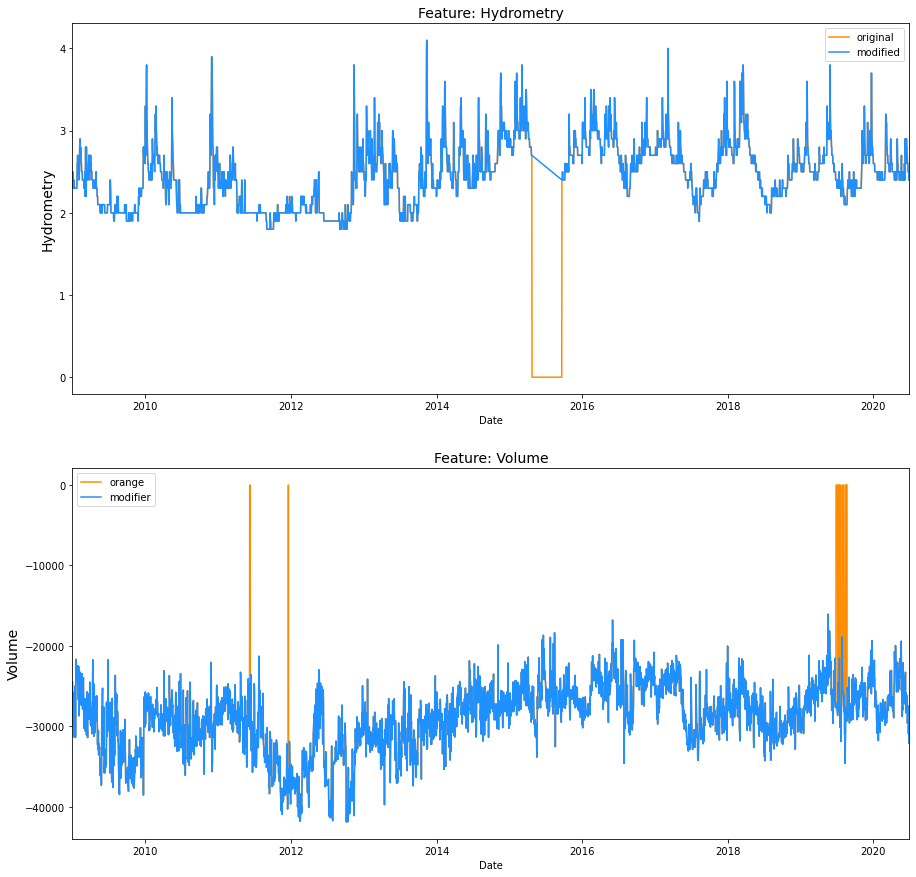

In [7]:
f, ax = plt.subplots(nrows=2, ncols=1, figsize=(15, 15))
old = df.River_Hydrometry.copy()
df['River_Hydrometry'] = np.where((df.River_Hydrometry == 0),np.nan, df.River_Hydrometry)

sns.lineplot(x=df.Date, y=old.fillna(np.inf), ax=ax[0], color='darkorange', label = 'original')
sns.lineplot(x=df.Date, y=df.River_Hydrometry.fillna(np.inf), ax=ax[0], color='dodgerblue', label = 'modified')
ax[0].set_title('Feature: Hydrometry', fontsize=14)
ax[0].set_ylabel(ylabel='Hydrometry', fontsize=14)

old = df.Drainage_Volume.copy()
df['Drainage_Volume'] = np.where((df.Drainage_Volume == 0), np.nan, df.Drainage_Volume)

sns.lineplot(x=df.Date, y=old.fillna(np.inf), ax=ax[1], color='darkorange', label='orange')
sns.lineplot(x=df.Date, y=df.Drainage_Volume.fillna(np.inf), ax=ax[1], color='dodgerblue', label='modifier')
ax[1].set_title('Feature: Volume', fontsize=14)
ax[1].set_ylabel(ylabel='Volume', fontsize=14)

for i in range(2):
    ax[i].set_xlim([date(2009, 1, 1), date(2020, 6, 30)])
plt.show()

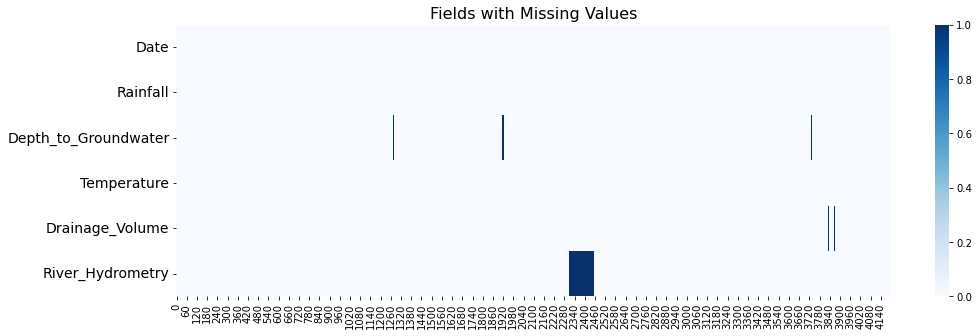

In [8]:
# Plot missing values
f, ax = plt.subplots(nrows=1, ncols=1, figsize=(16,5))
sns.heatmap(df.T.isna(), cmap='Blues')
ax.set_title('Fields with Missing Values', fontsize=16)
#for tick in ax.xaxis.get_major_ticks():
#    tick.label.set_fontsize(14)
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(14)
plt.show()

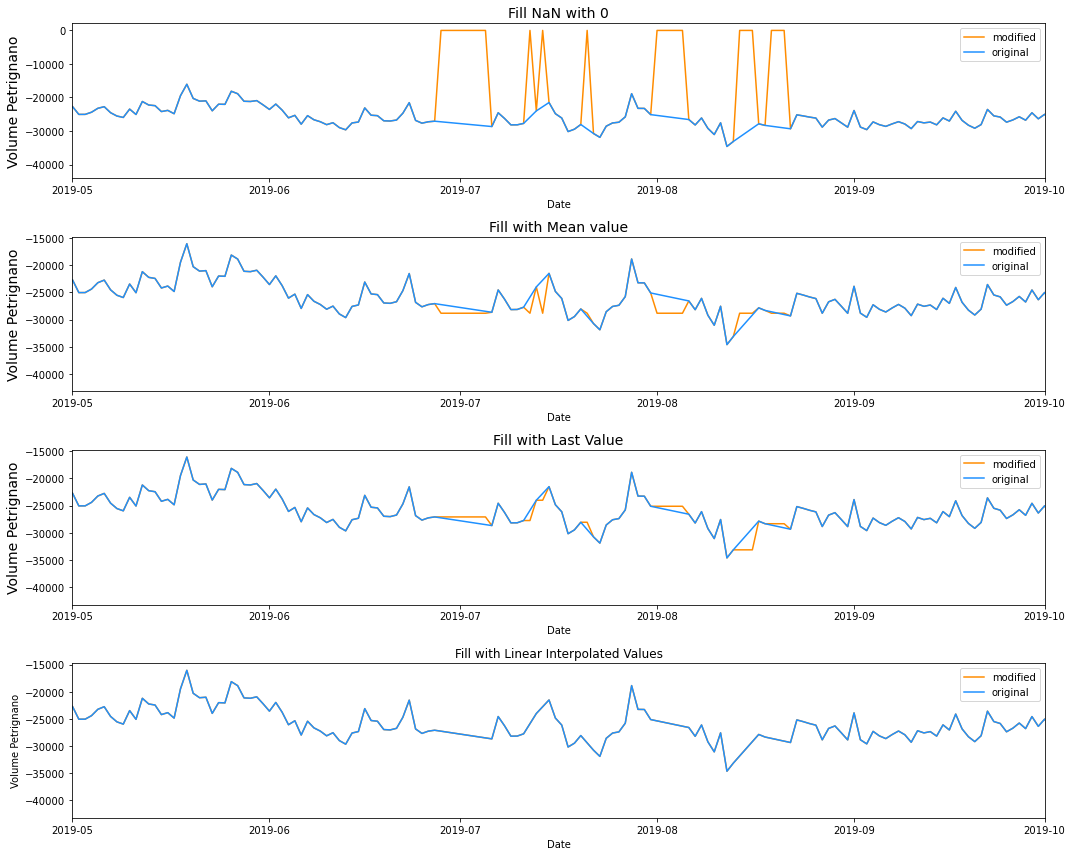

In [9]:
## 4 options for filling the NaN values

f, ax = plt.subplots(nrows=4, ncols=1, figsize=(15, 12))

# 1. Fill with outlier or zero
sns.lineplot(x=df.Date, y=df.Drainage_Volume.fillna(0), ax=ax[0], color='darkorange', label = 'modified')
sns.lineplot(x=df.Date, y=df.Drainage_Volume.fillna(np.inf), ax=ax[0], color='dodgerblue', label = 'original')
ax[0].set_title('Fill NaN with 0', fontsize=14)
ax[0].set_ylabel(ylabel='Volume Petrignano', fontsize=14)

# 2. Fill with Mean value
mean_val = df.Drainage_Volume.mean()
sns.lineplot(x=df.Date, y=df.Drainage_Volume.fillna(mean_val), ax=ax[1], color='darkorange', label='modified')
sns.lineplot(x=df.Date, y=df.Drainage_Volume.fillna(np.inf), ax=ax[1], color='dodgerblue', label='original')
ax[1].set_title('Fill with Mean value', fontsize=14)
ax[1].set_ylabel(ylabel='Volume Petrignano', fontsize=14)

# 3.Fill with Last value
sns.lineplot(x=df.Date, y=df.Drainage_Volume.ffill(), ax=ax[2], color='darkorange', label='modified')
sns.lineplot(x=df.Date, y=df.Drainage_Volume.fillna(np.inf), ax=ax[2], color='dodgerblue', label='original')
ax[2].set_title('Fill with Last Value', fontsize=14)
ax[2].set_ylabel('Volume Petrignano', fontsize=14)

# 4.Fill NaN values with Linearly Interpolated Value
sns.lineplot(x=df.Date, y=df.Drainage_Volume.interpolate(), ax=ax[3], color='darkorange', label='modified')
sns.lineplot(x=df.Date, y=df.Drainage_Volume.fillna(np.inf), ax=ax[3], color='dodgerblue', label = 'original')
ax[3].set_title('Fill with Linear Interpolated Values')
ax[3].set_ylabel('Volume Petrignano')

for i in range(4):
    ax[i].set_xlim([date(2019, 5, 1), date(2019, 10, 1)])
plt.tight_layout()
plt.show()

Filling NaNs with interpolated values in the best option in this case, but it requires knowledge of the neighbouring values.

In [10]:
df['Drainage_Volume'] = df['Drainage_Volume'].interpolate()
df['River_Hydrometry'] = df['River_Hydrometry'].interpolate()
df['Depth_to_Groundwater'] = df['Depth_to_Groundwater'].interpolate()

### Resampling

In our case, considering weekly data seems to be sufficient. Therefore, we will downsample the data to a weekly basis.

In [11]:
# Downsampling
df_downsampled = df[['Date',
                     'Depth_to_Groundwater',
                     'Temperature',
                     'Drainage_Volume',
                     'River_Hydrometry']].resample('7D', on='Date').mean().reset_index(drop=False)
df_downsampled['Rainfall'] = df[['Date',
                                 'Rainfall']].resample('7D', on='Date').sum().reset_index(drop=False)[['Rainfall']]

df = df_downsampled

### Stationarity

The check for stationarity can be done via three different approaches:

* **Visually**: plot time series and check for trends or seasonality
* **Basic statistics**: split time series and compare the mean and variance of each partition
* **Statistical test**: Augmented Dickey Fuller test

Below we will do the visual check first.

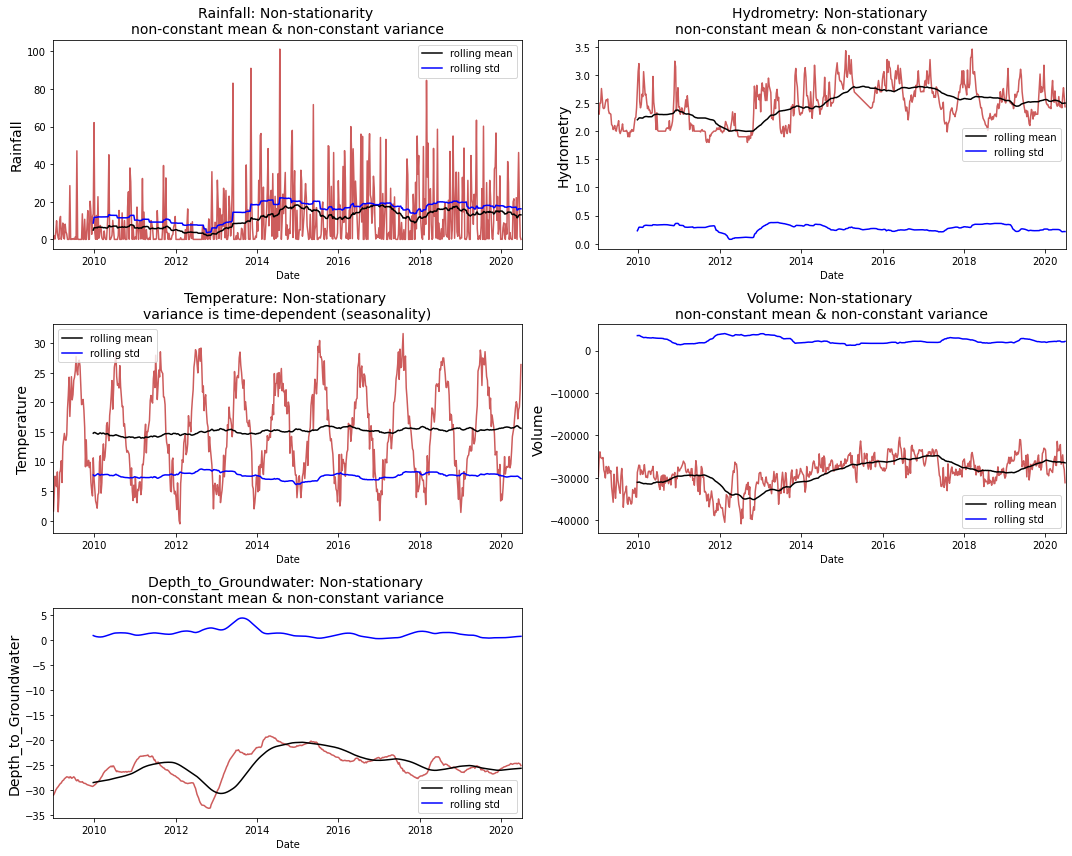

In [12]:
rolling_window = 52
f, ax = plt.subplots(nrows=3, ncols=2, figsize=(15,12))

sns.lineplot(x=df.Date, y=df.Rainfall, ax=ax[0, 0], color='indianred')
sns.lineplot(x=df.Date, y=df.Rainfall.rolling(rolling_window).mean(), ax=ax[0,0], color='black', label='rolling mean')
sns.lineplot(x=df.Date, y=df.Rainfall.rolling(rolling_window).std(), ax=ax[0,0], color='blue', label='rolling std')
ax[0, 0].set_title('Rainfall: Non-stationarity \nnon-constant mean & non-constant variance', fontsize=14)
ax[0, 0].set_ylabel(ylabel='Rainfall', fontsize=14)

sns.lineplot(x=df.Date, y=df.Temperature, ax=ax[1, 0], color='indianred')
sns.lineplot(x=df.Date, y=df.Temperature.rolling(rolling_window).mean(), ax=ax[1, 0], color='black', label='rolling mean')
sns.lineplot(x=df.Date, y=df.Temperature.rolling(rolling_window).std(), ax=ax[1, 0], color='blue', label='rolling std')
ax[1, 0].set_title('Temperature: Non-stationary \nvariance is time-dependent (seasonality)', fontsize=14)
ax[1, 0].set_ylabel(ylabel='Temperature', fontsize=14)

sns.lineplot(x=df.Date, y=df.River_Hydrometry, ax=ax[0,1], color='indianred')
sns.lineplot(x=df.Date, y=df.River_Hydrometry.rolling(rolling_window).mean(), ax=ax[0,1], color='black', label='rolling mean')
sns.lineplot(x=df.Date, y=df.River_Hydrometry.rolling(rolling_window).std(), ax=ax[0,1], color='blue', label='rolling std')
ax[0,1].set_title('Hydrometry: Non-stationary \nnon-constant mean & non-constant variance', fontsize=14)
ax[0,1].set_ylabel('Hydrometry', fontsize=14)

sns.lineplot(x=df.Date, y=df.Drainage_Volume, ax=ax[1,1], color='indianred')
sns.lineplot(x=df.Date, y=df.Drainage_Volume.rolling(rolling_window).mean(), ax=ax[1,1], color='black', label='rolling mean')
sns.lineplot(x=df.Date, y=df.Drainage_Volume.rolling(rolling_window).std(), ax=ax[1,1], color='blue', label='rolling std')
ax[1,1].set_title('Volume: Non-stationary \nnon-constant mean & non-constant variance', fontsize=14)
ax[1,1].set_ylabel('Volume', fontsize=14)

sns.lineplot(x=df.Date, y=df.Depth_to_Groundwater, ax=ax[2,0], color='indianred')
sns.lineplot(x=df.Date, y=df.Depth_to_Groundwater.rolling(rolling_window).mean(), ax=ax[2,0], color='black', label='rolling mean')
sns.lineplot(x=df.Date, y=df.Depth_to_Groundwater.rolling(rolling_window).std(), ax=ax[2,0], color='blue', label='rolling std')
ax[2,0].set_title('Depth_to_Groundwater: Non-stationary \nnon-constant mean & non-constant variance', fontsize=14)
ax[2,0].set_ylabel('Depth_to_Groundwater', fontsize=14)

for i in range(3):
    ax[i,0].set_xlim([date(2009, 1, 1), date(2020, 6, 30)])
    ax[i,1].set_xlim([date(2009, 1, 1), date(2020, 6, 30)])
    
f.delaxes(ax[2,1])
plt.tight_layout()
plt.show()

**Takeaway**: We can see all features except Temperature have a non-constant mean and non-constant variance. Therefore, none of these seem to be stationary. However, Temperature shows strong seasonality (hot in summer, cold in winter) and therefore it is not stationary either.

Next, we will check the underlying statistics. For this we will split the time series into two sections and check the mean and the variance.

In [13]:
num_partitions = 2
partition_length = int(len(df) / num_partitions)

partition1_mean = df.head(partition_length).mean()
partition1_var = df.head(partition_length).var()
partition2_mean = df.tail(partition_length).mean()
partition2_var = df.tail(partition_length).var()

In [14]:
stationarity_test = pd.concat([partition1_mean, partition2_mean, partition1_var, partition2_var], axis=1)
stationarity_test.columns = ['Partition 1 Mean', 'Partition 2 Mean', 'Partition 1 Variance', 'Partition 2 Variance']

def highlight_greater(x):
    temp = x.copy()
    temp = temp.round(0).astype(int)
    m1 = (temp['Partition 1 Mean'] == temp['Partition 2 Mean'])
    m2 = (temp['Partition 1 Variance'] == temp['Partition 2 Variance'])
    m3 = (temp['Partition 1 Mean'] < temp['Partition 2 Mean']+3) & (temp['Partition 1 Mean'] > temp['Partition 2 Mean']-3)
    m4 = (temp['Partition 1 Variance'] < temp['Partition 2 Variance']+3) & (temp['Partition 1 Variance'] > temp['Partition 2 Variance']-3)

    df1 = pd.DataFrame('background-color: ', index=x.index, columns=x.columns)
    #rewrite values by boolean masks
    df1['Partition 1 Mean'] = np.where(~m1, 'background-color: {}'.format('salmon'), df1['Partition 1 Mean'])
    df1['Partition 2 Mean'] = np.where(~m1, 'background-color: {}'.format('salmon'), df1['Partition 2 Mean'])
    df1['Partition 1 Mean'] = np.where(m3, 'background-color: {}'.format('gold'), df1['Partition 1 Mean'])
    df1['Partition 2 Mean'] = np.where(m3, 'background-color: {}'.format('gold'), df1['Partition 2 Mean'])
    df1['Partition 1 Mean'] = np.where(m1, 'background-color: {}'.format('mediumseagreen'), df1['Partition 1 Mean'])
    df1['Partition 2 Mean'] = np.where(m1, 'background-color: {}'.format('mediumseagreen'), df1['Partition 2 Mean'])

    df1['Partition 1 Variance'] = np.where(~m2, 'background-color: {}'.format('salmon'), df1['Partition 1 Variance'])
    df1['Partition 2 Variance'] = np.where(~m2, 'background-color: {}'.format('salmon'), df1['Partition 2 Variance'])
    df1['Partition 1 Variance'] = np.where(m4, 'background-color: {}'.format('gold'), df1['Partition 1 Variance'])
    df1['Partition 2 Variance'] = np.where(m4, 'background-color: {}'.format('gold'), df1['Partition 2 Variance'])
    df1['Partition 1 Variance'] = np.where(m2, 'background-color: {}'.format('mediumseagreen'), df1['Partition 1 Variance'])
    df1['Partition 2 Variance'] = np.where(m2, 'background-color: {}'.format('mediumseagreen'), df1['Partition 2 Variance'])

    return df1

stationarity_test.style.apply(highlight_greater, axis=None).format("{:20,.0f}")

,Partition 1 Mean,Partition 2 Mean,Partition 1 Variance,Partition 2 Variance
Depth_to_Groundwater,-26,-24,13,4
Temperature,15,15,58,56
Drainage_Volume,"-30,989","-26,684","12,053,921","5,955,484"
River_Hydrometry,2,3,0,0
Rainfall,8,14,197,306


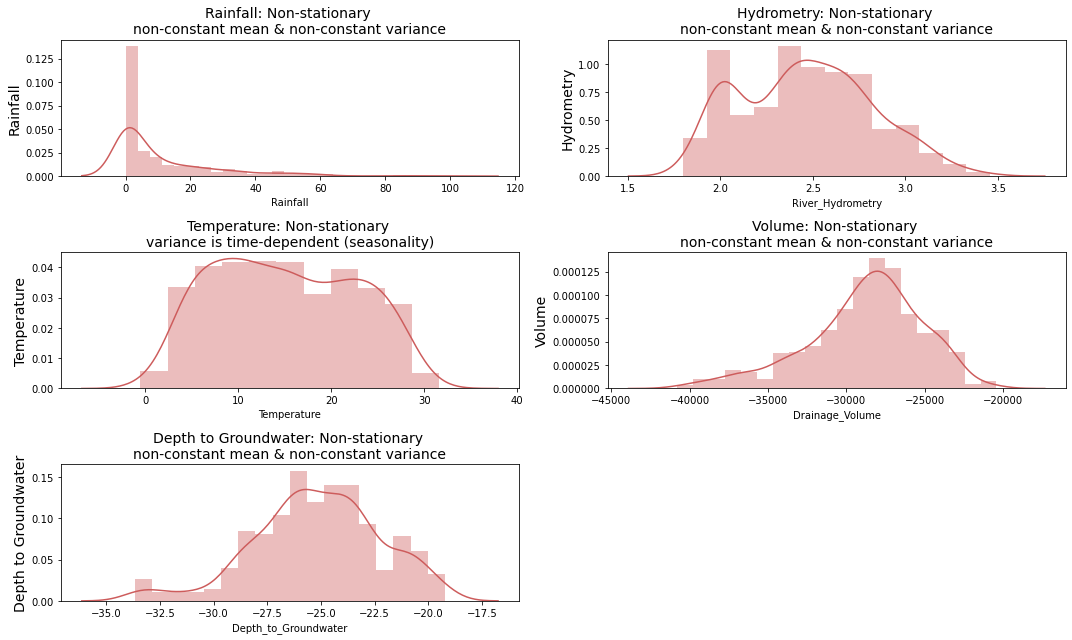

In [15]:
# Evaluate the histograms

f, ax = plt.subplots(nrows=3, ncols=2, figsize=(15, 9))

sns.distplot(df.Rainfall.fillna(np.inf), ax=ax[0, 0], color='indianred')
ax[0, 0].set_title('Rainfall: Non-stationary \nnon-constant mean & non-constant variance', fontsize=14)
ax[0, 0].set_ylabel(ylabel='Rainfall', fontsize=14)

sns.distplot(df.Temperature.fillna(np.inf), ax=ax[1, 0], color='indianred')
ax[1, 0].set_title('Temperature: Non-stationary \nvariance is time-dependent (seasonality)', fontsize=14)
ax[1, 0].set_ylabel(ylabel='Temperature', fontsize=14)

sns.distplot(df.River_Hydrometry.fillna(np.inf), ax=ax[0, 1], color='indianred')
ax[0, 1].set_title('Hydrometry: Non-stationary \nnon-constant mean & non-constant variance', fontsize=14)
ax[0, 1].set_ylabel(ylabel='Hydrometry', fontsize=14)

sns.distplot(df.Drainage_Volume.fillna(np.inf), ax=ax[1, 1], color='indianred')
ax[1, 1].set_title('Volume: Non-stationary \nnon-constant mean & non-constant variance', fontsize=14)
ax[1, 1].set_ylabel(ylabel='Volume', fontsize=14)

sns.distplot(df.Depth_to_Groundwater.fillna(np.inf), ax=ax[2, 0], color='indianred')
ax[2, 0].set_title('Depth to Groundwater: Non-stationary \nnon-constant mean & non-constant variance', fontsize=14)
ax[2, 0].set_ylabel(ylabel='Depth to Groundwater', fontsize=14)

f.delaxes(ax[2, 1])
plt.tight_layout()
plt.show()

In [16]:
# Augmented Dickey-Fuller (ADF)
# is a statistical test called a unit root test. Unit roots are 
# a cause for non-stationarity. If series has an unit root,
# is not stationary

from statsmodels.tsa.stattools import adfuller

result = adfuller(df.Depth_to_Groundwater.values)
adf_stat = result[0]
p_val = result[1]
crit_val_1 = result[4]['1%']
crit_val_5 = result[4]['5%']
crit_val_10 = result[4]['10%']

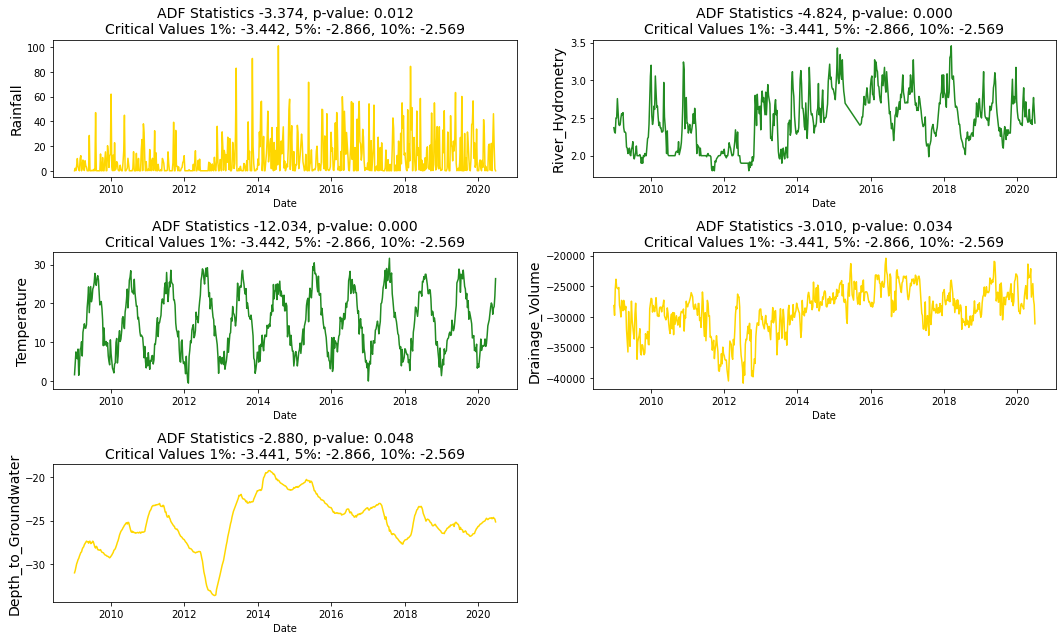

In [17]:
f, ax = plt.subplots(nrows=3, ncols=2, figsize=(15, 9))

def visualize_adfuller_results(series, title, ax):
    result = adfuller(series)
    significance_level = 0.05
    adf_stat = result[0]
    p_val = result[1]
    crit_val_1 = result[4]['1%']
    crit_val_2 = result[4]['5%']
    cirt_val_10 = result[4]['10%']
    
    if (p_val < significance_level) & ((adf_stat < crit_val_1)):
        linecolor = 'forestgreen'
    elif (p_val < significance_level) & (adf_stat < crit_val_5):
        linecolor = 'gold'
    elif (p_val < singnificance_level) & (adf_stat < crit_val_10):
        linecolor = 'orange'
    else:
        linecolor = 'indianred'
    sns.lineplot(x=df.Date, y=series, ax=ax, color=linecolor)
    ax.set_title(f'ADF Statistics {adf_stat:0.3f}, p-value: {p_val:0.3f}\nCritical Values 1%: {crit_val_1:0.3f}, 5%: {crit_val_5:0.3f}, 10%: {crit_val_10:0.3f}', fontsize=14)
    ax.set_ylabel(ylabel=title, fontsize=14)
    
visualize_adfuller_results(df.Rainfall.values, 'Rainfall', ax[0, 0])
visualize_adfuller_results(df.Temperature.values, 'Temperature', ax[1, 0])
visualize_adfuller_results(df.River_Hydrometry.values, 'River_Hydrometry', ax[0, 1])
visualize_adfuller_results(df.Drainage_Volume.values, 'Drainage_Volume', ax[1, 1])
visualize_adfuller_results(df.Depth_to_Groundwater.values, 'Depth_to_Groundwater', ax[2, 0])
    
f.delaxes(ax[2, 1])
plt.tight_layout()
plt.show()

**Note**: If data is not stationarity but we want to use a model that requires with characteristic, the data has to be transformed. However, if the data is not stationarity to begin with, we should rethink the choice of model.

The two most common methods to achieve stationarity are:
- **Transformation**: e.g. log or square root to stabilize non-constant variance
- **Differencing**: substracts the current value from the previous

In [18]:
# Log Transform of absolute values
# Log transform of negative values will return NaN
df['Depth_to_Groundwater_log'] = np.log(abs(df.Depth_to_Groundwater))

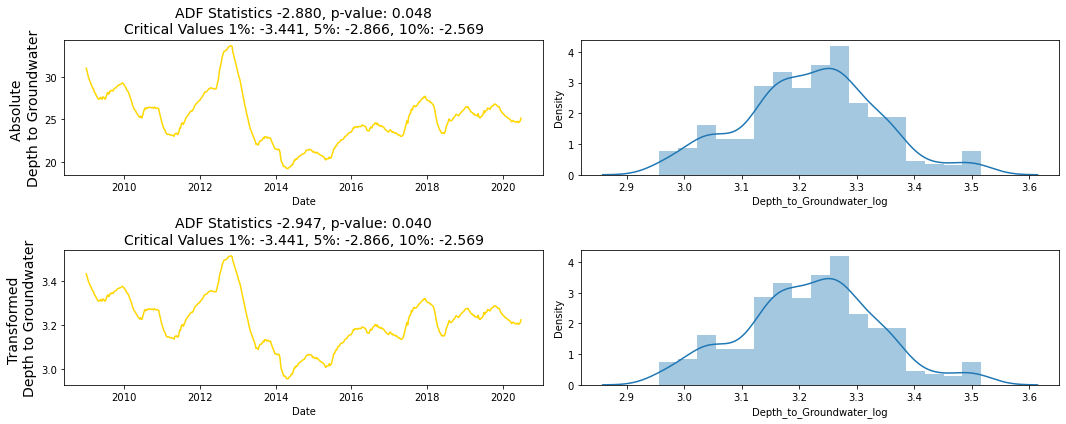

In [19]:
f, ax = plt.subplots(nrows=2, ncols=2, figsize=(15,6))
visualize_adfuller_results(abs(df.Depth_to_Groundwater), 'Absolute \nDepth to Groundwater', ax[0, 0])
sns.distplot(df.Depth_to_Groundwater_log, ax=ax[0, 1])
visualize_adfuller_results(df.Depth_to_Groundwater_log, 'Transformed \nDepth to Groundwater', ax[1,0])
sns.distplot(df.Depth_to_Groundwater_log, ax=ax[1,1])

plt.tight_layout()
plt.show()

Differencing can be done in different orders:
- First order differencing
- Second-order differencing
- and so on...

In [20]:
# First Order Differencing
ts_diff = np.diff(df.Depth_to_Groundwater)
df['Depth_to_Groundwater_diff_1'] = np.append([0], ts_diff)

# Second Order Differencing
ts_diff = np.diff(df.Depth_to_Groundwater_diff_1)
df['Depth_to_Groundwater_diff_2'] = np.append([0], ts_diff)

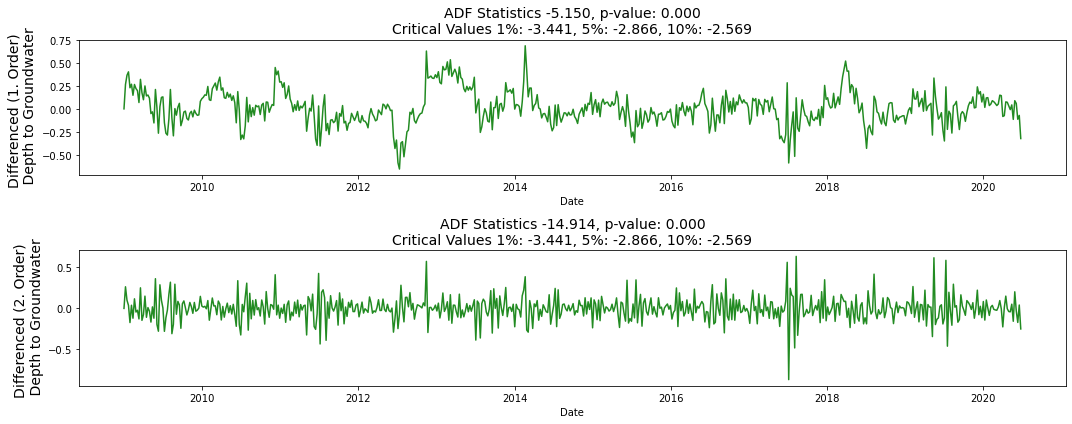

In [21]:
f, ax = plt.subplots(nrows=2, ncols=1, figsize=(15, 6))

visualize_adfuller_results(df.Depth_to_Groundwater_diff_1, 'Differenced (1. Order) \n Depth to Groundwater', ax[0])
visualize_adfuller_results(df.Depth_to_Groundwater_diff_2, 'Differenced (2. Order) \n Depth to Groundwater', ax[1])
plt.tight_layout()
plt.show()

The differencing can be reverted if the first value before differencing is known. In this case, we can accumulate all values with the function **.cumsum()** and add the first value of the original time series.

In [22]:
df.Depth_to_Groundwater.equals(df.Depth_to_Groundwater_diff_1.cumsum() + df.Depth_to_Groundwater.iloc[0])

True

### 4. Feature Engineering

#### Time Features

In [23]:
df['year'] = pd.DatetimeIndex(df['Date']).year
df['month'] = pd.DatetimeIndex(df['Date']).month
df['day'] = pd.DatetimeIndex(df['Date']).day
df['day_of_year'] = pd.DatetimeIndex(df['Date']).dayofyear
df['week_of_year'] = pd.DatetimeIndex(df['Date']).weekofyear
df['quarter'] = pd.DatetimeIndex(df['Date']).quarter
df['season'] = df.month%12 // 3 + 1

df[['Date', 'year', 'month', 'day', 'day_of_year', 'week_of_year', 'quarter', 'season']].head()

,Date,year,month,day,day_of_year,week_of_year,quarter,season
0,2009-01-01,2009,1,1,1,1,1,1
1,2009-01-08,2009,1,8,8,2,1,1
2,2009-01-15,2009,1,15,15,3,1,1
3,2009-01-22,2009,1,22,22,4,1,1
4,2009-01-29,2009,1,29,29,5,1,1


#### Encoding Cyclical Features

The new time features are cyclical. For example, the feature `month` cycles between 1 and 12 for every year. While the difference between each month increments by 1 during the year, between two years the `month` feature jumps from 12 (December) to 1 (January). This results in a -11 difference, which can confuse a lot models.

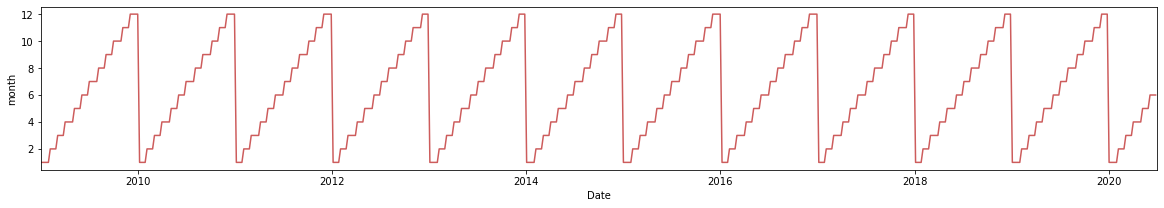

In [24]:
f, ax = plt.subplots(nrows=1, ncols=1, figsize=(20,3))

sns.lineplot(x=df.Date, y=df.month, color='indianred')
ax.set_xlim([date(2009, 1, 1), date(2020, 6, 30)])
plt.show()

#### Decomposition
The characteristics of a time series are:
- Trend and Level
- Seasonality
- Random / Noise

We will use `seasonal_decompose()`:
- Additive: *y(t) = Level + Trend + Seasonality + Noise*
- Multiplicative: *y(t) = Level ∗ Trend ∗ Seasonality ∗ Noise*

In [25]:
from statsmodels.tsa.seasonal import seasonal_decompose

decompose_cols = ['Rainfall', 'Temperature', 'Drainage_Volume', 'River_Hydrometry', 'Depth_to_Groundwater']

for col in decompose_cols:
    decomp = seasonal_decompose(df[col], freq=52, model='additive', extrapolate_trend='freq')
    df[f"{col}_trend"] = decomp.trend
    df[f"{col}_seasonal"] = decomp.seasonal

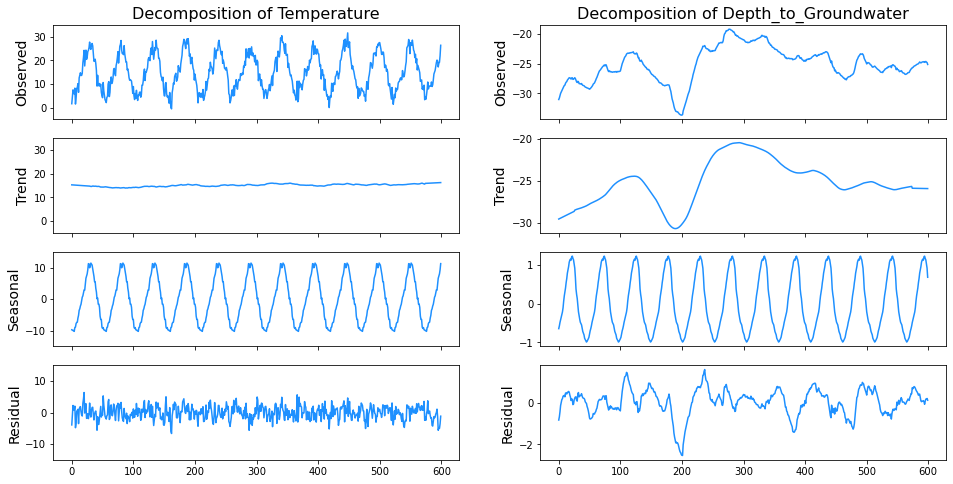

In [26]:
fig, ax = plt.subplots(ncols=2, nrows=4, sharex=True, figsize=(16,8))
res = seasonal_decompose(df.Temperature, freq=52, model='additive', extrapolate_trend='freq')

ax[0,0].set_title('Decomposition of Temperature', fontsize=16)
res.observed.plot(ax=ax[0,0], legend=False, color='dodgerblue')
ax[0,0].set_ylabel('Observed', fontsize=14)
ax[0,0].set_ylim([-5, 35])

res.trend.plot(ax=ax[1,0], legend=False, color='dodgerblue')
ax[1,0].set_ylabel('Trend', fontsize=14)
ax[1,0].set_ylim([-5, 35])

res.seasonal.plot(ax=ax[2,0], legend=False, color='dodgerblue')
ax[2,0].set_ylabel('Seasonal', fontsize=14)
ax[2,0].set_ylim([-15, 15])

res.resid.plot(ax=ax[3,0], legend=False, color='dodgerblue')
ax[3,0].set_ylabel('Residual', fontsize=14)
ax[3,0].set_ylim([-15, 15])

ax[0,1].set_title('Decomposition of Depth_to_Groundwater', fontsize=16)

res = seasonal_decompose(df.Depth_to_Groundwater, freq=52, model='additive', extrapolate_trend='freq')

res.observed.plot(ax=ax[0, 1], legend=False, color='dodgerblue')
ax[0,1].set_ylabel('Observed', fontsize=14)

res.trend.plot(ax=ax[1,1], legend=False, color='dodgerblue')
ax[1,1].set_ylabel('Trend', fontsize=14)

res.seasonal.plot(ax=ax[2,1], legend=False, color='dodgerblue')
ax[2,1].set_ylabel('Seasonal', fontsize=14)

res.resid.plot(ax=ax[3,1], legend=False, color='dodgerblue')
ax[3,1].set_ylabel('Residual', fontsize=14)

plt.show()

In [27]:
df[['Rainfall', 'Rainfall_trend', 'Rainfall_seasonal', 
          'Temperature', 'Temperature_trend', 'Temperature_seasonal', 
          'Drainage_Volume', 'Drainage_Volume_trend', 'Drainage_Volume_seasonal',
          'River_Hydrometry', 'River_Hydrometry_trend', 'River_Hydrometry_seasonal', 
          'Depth_to_Groundwater', 'Depth_to_Groundwater_trend', 'Depth_to_Groundwater_seasonal']].head()\
.style.set_properties(subset=['Rainfall_trend', 'Rainfall_seasonal', 
                              'Temperature_trend', 'Temperature_seasonal', 
                              'Drainage_Volume_trend', 'Drainage_Volume_seasonal', 
                              'River_Hydrometry_trend', 'River_Hydrometry_seasonal',
                              'Depth_to_Groundwater_trend', 'Depth_to_Groundwater_seasonal'
                             ], **{'background-color': 'dodgerblue'})

,Rainfall,Rainfall_trend,Rainfall_seasonal,Temperature,Temperature_trend,Temperature_seasonal,Drainage_Volume,Drainage_Volume_trend,Drainage_Volume_seasonal,River_Hydrometry,River_Hydrometry_trend,River_Hydrometry_seasonal,Depth_to_Groundwater,Depth_to_Groundwater_trend,Depth_to_Groundwater_seasonal
0,0.000000,5.644061,4.822633,1.657143,15.329959,-9.739920,-28164.918857,-32404.467037,1551.335303,2.371429,2.164913,0.207547,-31.048571,-29.571657,-0.643767
1,2.000000,5.663654,-5.096388,4.571429,15.312814,-9.838787,-29755.789714,-32374.371773,938.070633,2.314286,2.167252,0.186527,-30.784286,-29.535110,-0.572078
2,0.200000,5.683247,-5.019971,7.528571,15.295668,-10.002955,-25463.190857,-32344.276508,832.934327,2.300000,2.169592,0.105423,-30.420000,-29.498564,-0.484281
3,4.100000,5.702840,3.454367,6.214286,15.278522,-9.973161,-23854.422857,-32314.181244,518.836188,2.500000,2.171931,0.131993,-30.018571,-29.462017,-0.417712
4,9.900000,5.722433,-3.895493,5.771429,15.261377,-10.246938,-25210.532571,-32284.085980,238.454010,2.500000,2.174270,0.152668,-29.790000,-29.425470,-0.362900


#### Lag

We will create lags using `.shift()`

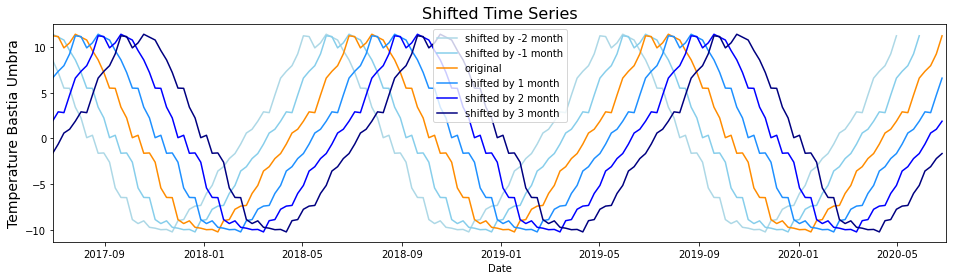

In [28]:
weeks_in_month = 4

df['Temperature_seasonal_shift_r_2M'] = df.Temperature_seasonal.shift(-2*weeks_in_month)
df['Temperature_seasonal_shift_r_1M'] = df.Temperature_seasonal.shift(-1*weeks_in_month)
df['Temperature_seasonal_shift_1M'] = df.Temperature_seasonal.shift(1*weeks_in_month)
df['Temperature_seasonal_shift_2M'] = df.Temperature_seasonal.shift(2*weeks_in_month)
df['Temperature_seasonal_shift_3M'] = df.Temperature_seasonal.shift(3*weeks_in_month)

df['Drainage_Volume_seasonal_shift_r_2M'] = df.Drainage_Volume_seasonal.shift(-2*weeks_in_month)
df['Drainage_Volume_seasonal_shift_r_1M'] = df.Drainage_Volume_seasonal.shift(-1*weeks_in_month)
df['Drainage_Volume_seasonal_shift_1M'] = df.Drainage_Volume_seasonal.shift(1*weeks_in_month)
df['Drainage_Volume_seasonal_shift_2M'] = df.Drainage_Volume_seasonal.shift(2*weeks_in_month)
df['Drainage_Volume_seasonal_shift_3M'] = df.Drainage_Volume_seasonal.shift(3*weeks_in_month)

df['River_Hydrometry_seasonal_shift_r_2M'] = df.River_Hydrometry_seasonal.shift(-2*weeks_in_month)
df['River_Hydrometry_seasonal_shift_r_1M'] = df.River_Hydrometry_seasonal.shift(-1*weeks_in_month)
df['River_Hydrometry_seasonal_shift_1M'] = df.River_Hydrometry_seasonal.shift(1*weeks_in_month)
df['River_Hydrometry_seasonal_shift_2M'] = df.River_Hydrometry_seasonal.shift(2*weeks_in_month)
df['River_Hydrometry_seasonal_shift_3M'] = df.River_Hydrometry_seasonal.shift(3*weeks_in_month)

fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(16,4))
sns.lineplot(x=df.Date, y=df.Temperature_seasonal_shift_r_2M, label='shifted by -2 month', ax=ax, color='lightblue')
sns.lineplot(x=df.Date, y=df.Temperature_seasonal_shift_r_1M, label='shifted by -1 month', ax=ax, color='skyblue')

sns.lineplot(x=df.Date, y=df.Temperature_seasonal, label='original', ax=ax, color='darkorange')

sns.lineplot(x=df.Date, y=df.Temperature_seasonal_shift_1M, label='shifted by 1 month', ax=ax, color='dodgerblue')
sns.lineplot(x=df.Date, y=df.Temperature_seasonal_shift_2M, label='shifted by 2 month', ax=ax, color='blue')
sns.lineplot(x=df.Date, y=df.Temperature_seasonal_shift_3M, label='shifted by 3 month', ax=ax, color='navy')

ax.set_title('Shifted Time Series', fontsize=16)

ax.set_xlim([date(2017, 6, 30), date(2020, 6, 30)])
ax.set_ylabel(ylabel='Temperature Bastia Umbra', fontsize=14)

plt.show()

### 5. Exploratory Data Analysis

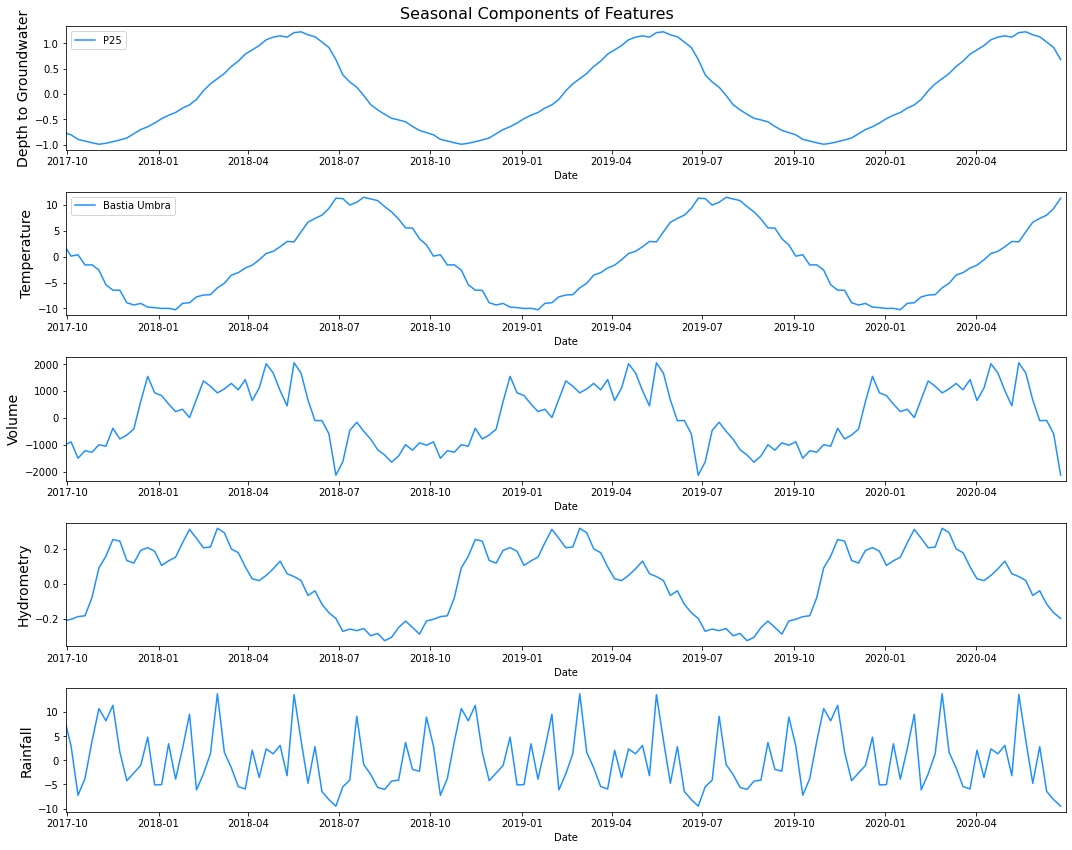

In [29]:
f, ax = plt.subplots(nrows=5, ncols=1, figsize=(15, 12))
f.suptitle('Seasonal Components of Features', fontsize=16)
sns.lineplot(x=df.Date, y=df.Depth_to_Groundwater_seasonal, ax=ax[0], color='dodgerblue', label='P25')
ax[0].set_ylabel(ylabel='Depth to Groundwater', fontsize=14)

sns.lineplot(x=df.Date, y=df.Temperature_seasonal, ax=ax[1], color='dodgerblue', label='Bastia Umbra')
ax[1].set_ylabel(ylabel='Temperature', fontsize=14)

sns.lineplot(x=df.Date, y=df.Drainage_Volume_seasonal, ax=ax[2], color='dodgerblue')
ax[2].set_ylabel(ylabel='Volume', fontsize=14)

sns.lineplot(x=df.Date, y=df.River_Hydrometry_seasonal, ax=ax[3], color='dodgerblue')
ax[3].set_ylabel(ylabel='Hydrometry', fontsize=14)

sns.lineplot(x=df.Date, y=df.Rainfall_seasonal, ax=ax[4], color='dodgerblue')
ax[4].set_ylabel(ylabel='Rainfall', fontsize=14)

for i in range(5):
    ax[i].set_xlim([date(2017, 9, 30), date(2020, 6, 30)])
plt.tight_layout()
plt.show()

**Takeaway**:Let's begin by plotting the seasonal components of each feature and comparing the minima and maxima. By doing this, we can already gain some insights:
- The depth of ground water reaches its maximum around May/June and its minimum around November/December
- The temperature reaches its maximum around August and its minimum around January
- The volume reaches its maximum around June and its minimum around August/September. It takes longer to reach its maximum than to reach its minimum
- The hydrometry reaches its maximum around March and its minimum around September
- The volume and hydrometry reach their minimum roughly around the same time
- The volume and hydrometry reach their minimum when the temperature reaches its maximum
- Temperature lags begind depth to groundwater by around 2 to 3 month

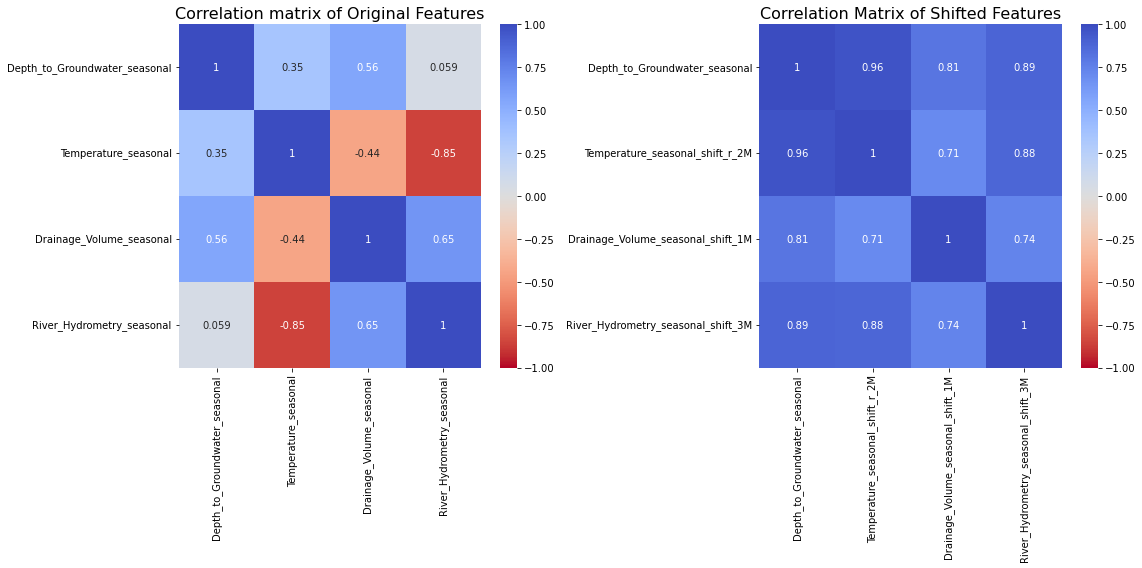

In [30]:
f, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))

original_cols=['Depth_to_Groundwater_seasonal','Temperature_seasonal','Drainage_Volume_seasonal','River_Hydrometry_seasonal']

# Correlation matrix
corrmat = df[original_cols].corr()

sns.heatmap(corrmat, annot=True, vmin=-1, vmax=1, cmap='coolwarm_r', ax=ax[0])
ax[0].set_title('Correlation matrix of Original Features', fontsize=16)

shifted_cols=['Depth_to_Groundwater_seasonal','Temperature_seasonal_shift_r_2M','Drainage_Volume_seasonal_shift_1M','River_Hydrometry_seasonal_shift_3M']
corrmat = df[shifted_cols].corr()

sns.heatmap(corrmat, annot=True, vmin=-1, vmax=1, cmap='coolwarm_r', ax=ax[1])
ax[1].set_title('Correlation Matrix of Shifted Features', fontsize=16)

plt.tight_layout()
plt.show()

**Takeaway**: We can see that the correlation increases to the target value if we use time shifted features in comparison to the original features.

#### Autocorrelation Analysis

**Note**: The autocorrelation analysis helps to identify the AR and MA parameters for the `ARIMA` model.

- **Autocorrelation Function (ACF)**: Correlation between time series with a lagged version of itself. The autocorrelation function starts at lag 0, which is the correlation of time series with itself and therefore results in a correlation of 1. *MA parameter is q significant lags.*

- Partial Autocorrelation Function (PACF): Additional correlation explained by each successive lag term. *AR parameter is p significant lags.*

Autocorrelation helps in detecting seasonality.

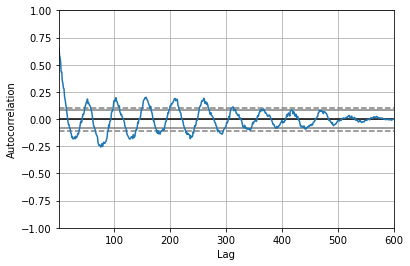

In [31]:
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(df.Depth_to_Groundwater_diff_1)
plt.show()

**Takeaway**: As we can infer from the graph above, the autocorrelation continues to decrease as the lag increases, confirming that there is no linear association between observations separated by larger lags.

For the AR process, we expect that the ACF plot will gradually decrease and simultaneously the PACF should have a sharp drop after p significant lags. To define a MA process, we expect the opposite from the ACF and PACF plots. meaning that: the ACF should show a sharp drop after a certain q number of lags while PACF should show a geometric or gradual decreasing trend.

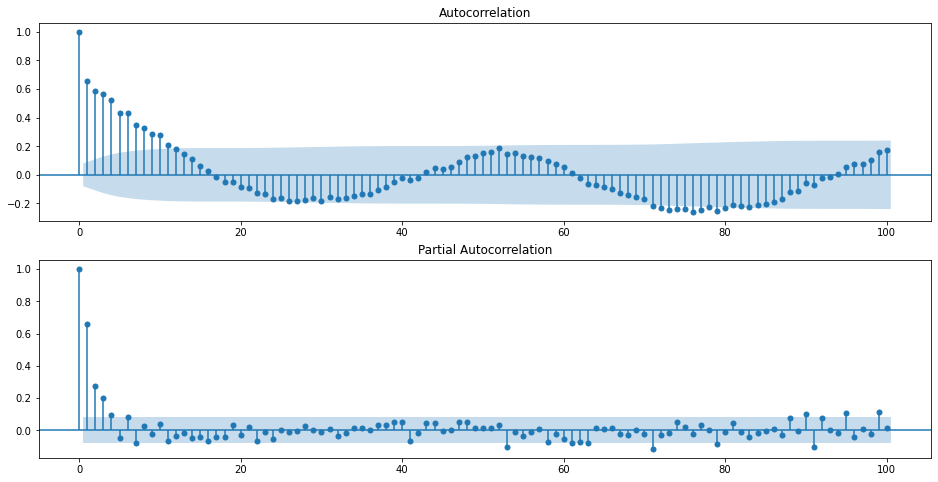

In [33]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

f, ax = plt.subplots(nrows=2, ncols=1, figsize=(16, 8))

plot_acf(df.Depth_to_Groundwater_diff_1, lags=100, ax=ax[0])
plot_pacf(df.Depth_to_Groundwater_diff_1, lags=100, ax=ax[1])
plt.show()

**Takeaway**: We can see some sinusoidal shape in both ACF and PACF functions. This suggests that both AR and MA processes are present.

## 6. Cross Validation

In [36]:
from sklearn.model_selection import TimeSeriesSplit

N_SPLITS = 3
X = df.Date
y= df.Depth_to_Groundwater

folds = TimeSeriesSplit(n_splits=N_SPLITS)

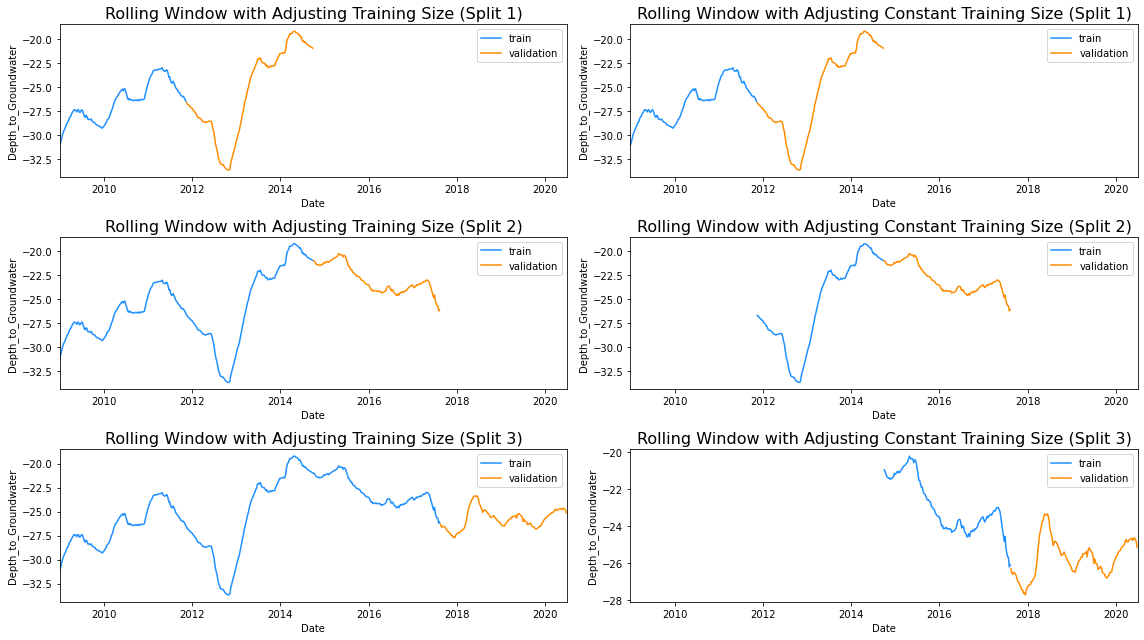

In [37]:
f, ax = plt.subplots(nrows=N_SPLITS, ncols=2, figsize=(16, 9))

for i, (train_index, valid_index) in enumerate(folds.split(X)):
    X_train, X_valid = X[train_index], X[valid_index]
    y_train, y_valid = y[train_index], y[valid_index]
    
    sns.lineplot(x=X_train, y=y_train, ax=ax[i,0], color='dodgerblue', label='train')
    sns.lineplot(x=X_train[len(X_train)- len(X_valid):(len(X_train)-len(X_valid)+len(X_valid))],
                 y= y_train[len(X_train)- len(X_valid):(len(X_train)-len(X_valid) + len(X_valid))],
                 ax=ax[i,1], color='dodgerblue', label='train')
    for j in range(2):
        sns.lineplot(x= X_valid, y=y_valid, ax=ax[i,j], color='darkorange', label='validation')
    ax[i,0].set_title(f"Rolling Window with Adjusting Training Size (Split {i+1})", fontsize=16)
    ax[i,1].set_title(f"Rolling Window with Adjusting Constant Training Size (Split {i+1})", fontsize=16)
    
for i in range(N_SPLITS):
    ax[i, 0].set_xlim([date(2009, 1, 1), date(2020, 6, 30)])
    ax[i, 1].set_xlim([date(2009, 1, 1), date(2020, 6, 30)])
plt.tight_layout()
plt.show()

## 7. Models

**Note**: Our dataset is a multivariate time series because it has multiple features that are all time-dependent. We can convert our target value `Depth to Groundwater` to an univariate time series.

We will focus on a quarterly forecast. We will use the Q2 2020 as the test data and the remaining data will be split by quarter for Cross-Validation.
We will evaluate the Mean Absolute Error (MAE) and Root Mean Square Error (RMSE) of the models.

#### Models for Univariate Time Series

- Stochastic Models
 - Naive Approach
 - Moving Average
 - Exponential Smoothing
 - ARIMA
 - Prophet
- Deep Learning
 - LSTM
 - GRU

In [42]:
df['quarter_idx'] = (df.quarter != df.quarter.shift(1)).cumsum()

# define the target and features
target = 'Depth_to_Groundwater'
feature = [feature for feature in df.columns if feature != target]

N_SPLITS = 46

X= df[df.quarter_idx < N_SPLITS][features]
y = df[df.quarter_idx < N_SPLITS][target]

X_test = df[df.quarter_idx == N_SPLITS][features].reset_index(drop=True)
y_test = df[df.quarter_idx == N_SPLITS][target].reset_index(drop=True)

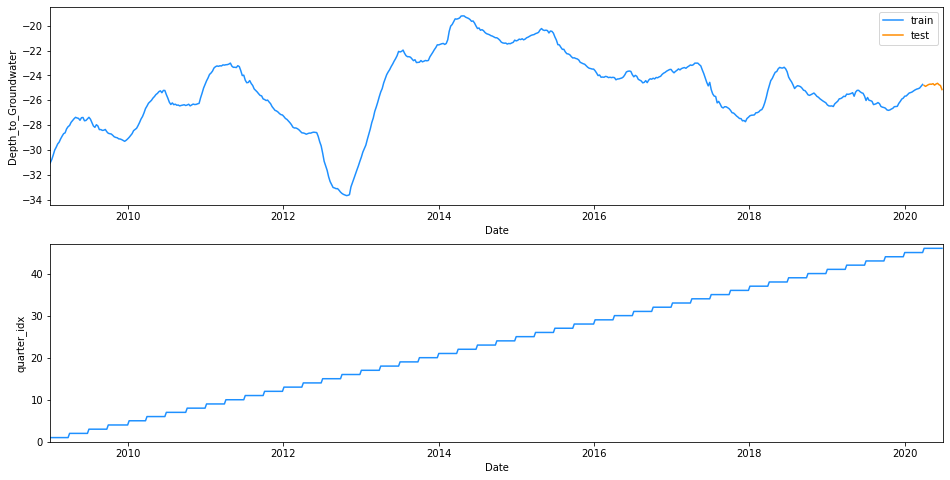

In [45]:
folds = np.linspace(0, N_SPLITS-3, num=N_SPLITS-2)

f, ax = plt.subplots(nrows=2, ncols=1, figsize=(16, 8))

sns.lineplot(x=X.Date, y=y, ax=ax[0], color='dodgerblue', label='train')
sns.lineplot(x=X_test.Date, y=y_test, ax=ax[0], color='darkorange', label='test')

sns.lineplot(x=df.Date, y=df.quarter_idx, ax=ax[1], color='dodgerblue')
ax[0].set_xlim([date(2009, 1, 1), date(2020, 6, 30)])
ax[1].set_xlim([date(2009, 1, 1), date(2020, 6, 30)])
ax[1].set_ylim([0, N_SPLITS+1])
#ax[0].set_ylim([-28, -23])

plt.show()

In [50]:
# function to evaluate the approaches
def plot_approach_evaluation(y_pred, score_mae, score_rsme, approach_name):
    f, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))
    f.suptitle(approach_name, fontsize=16)
    sns.lineplot(x=X.Date, y=y, ax=ax[0], color='dodgerblue', label='Training', linewidth=2)
    sns.lineplot(x=X_test.Date, y=y_test, ax=ax[0], color='gold', label='Ground Truth', linewidth=2)
    sns.lineplot(x=X_test.Date, y=y_pred, ax=ax[0], color='darkorange', label='Predicted', linewidth=2)
    ax[0].set_xlim([date(2018, 6, 30), date(2020, 6, 30)])
    ax[0].set_ylim([-27, -23])
    ax[0].set_title(f'Prediction \n MAE: {mean_absolute_error(y_test, y_pred):.2f}, RSME: {math.sqrt(mean_squared_error(y_valid,y_valid_pred)):.2f}', fontsize=14)
    ax[0].set_xlabel(xlabel='Date', fontsize=14)
    ax[0].set_ylabel(ylabel='Depth to Groundwater P25', fontsize=14)
    
    sns.lineplot(x=folds, y=score_mae, color='gold', label='MAE', ax=ax[1])#marker='o',
    sns.lineplot(x=folds, y=score_rsme, color='indianred', label='RSME', ax=ax[1])
    ax[1].set_title('Loss', fontsize=14)
    ax[1].set_xlabel(xlabel='Fold', fontsize=14)
    ax[1].set_ylabel(ylabel='Loss', fontsize=14)
    ax[1].set_ylim([0, 4])
    plt.show()

#### Naive Approach

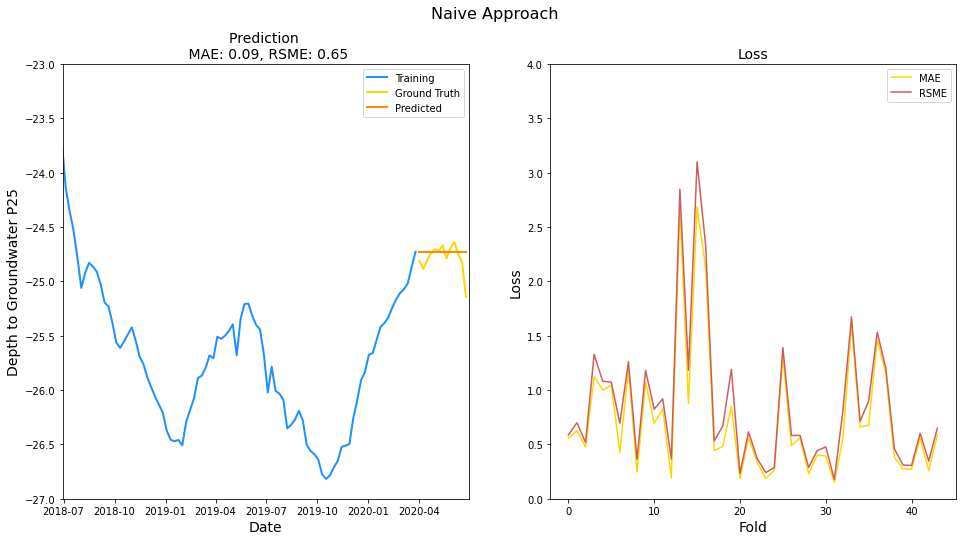

In [51]:
score_mae = []
score_rsme = []
for fold, valid_quarter_id in enumerate(range(2, N_SPLITS)):
    # Get indices of this fold
    train_index = df[df.quarter_idx < valid_quarter_id].index
    valid_index = df[df.quarter_idx == valid_quarter_id].index
    
    # Prepare training and validation data for this fold
    #X_train, X_valid = X.iloc[train_index], X.iloc[valid_index]
    y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]
    
    # Initialize y_valid_pred
    y_valid_pred = pd.Series(np.ones(len(y_valid)))
    
    # Prediction: Naive Approach
    y_valid_pred = y_valid_pred * y_train.iloc[-1]
    
    # Calculate metrics
    score_mae.append(mean_absolute_error(y_valid, y_valid_pred))
    score_rsme.append(math.sqrt(mean_squared_error(y_valid, y_valid_pred)))
    
y_pred = pd.Series(np.ones(len(X_test))) * y.iloc[-1]

plot_approach_evaluation(y_pred, score_mae, score_rsme, 'Naive Approach')

#### Moving Average

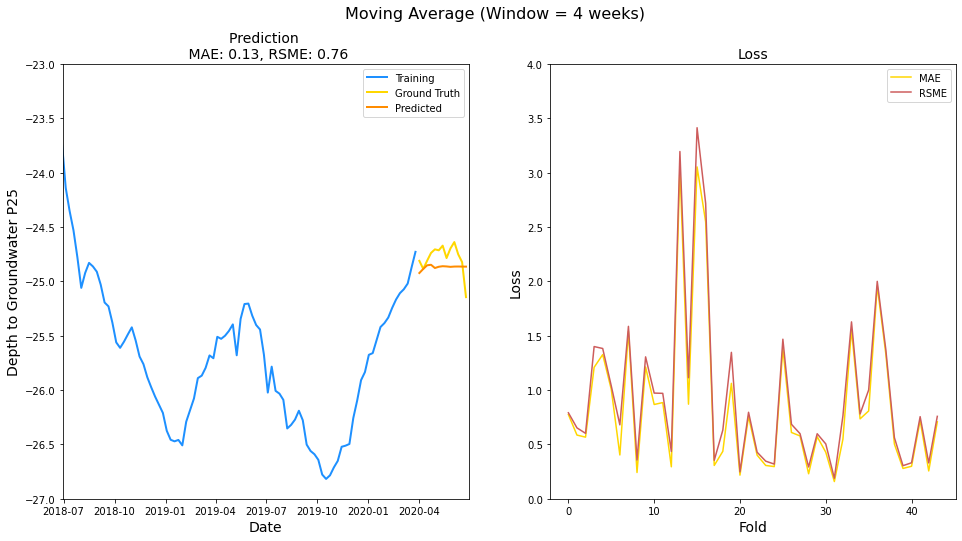

In [52]:
score_mae = []
score_rsme = []
for fold, valid_quarter_id in enumerate(range(2, N_SPLITS)):
    # Get indices for this fold
    train_index = df[df.quarter_idx < valid_quarter_id].index
    valid_index = df[df.quarter_idx == valid_quarter_id].index
    
    # Prepare training and validation data for this fold
    #X_train, X_valid = X.iloc[train_index], X.iloc[valid_index]
    y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]
    
    # Initial y_valid_pred
    y_valid_pred = pd.Series(np.ones(len(y_valid)))
    
    # Prediction: Moving Average
    for i in range(len(y_valid_pred)):
        y_valid_pred.iloc[i] = y_train.append(y_valid_pred.iloc[:(i)]).reset_index(drop=True).rolling(4).mean().iloc[-1]
        
    # Calculate metrics
    score_mae.append(mean_absolute_error(y_valid, y_valid_pred))
    score_rsme.append(math.sqrt(mean_squared_error(y_valid, y_valid_pred)))
    
y_pred = pd.Series(np.zeros(len(X_test)))

for i in range(len(y_pred)):
    y_pred.iloc[i] = y.append(y_pred.iloc[:(i)]).reset_index(drop=True).rolling(4).mean().iloc[-1]
    
plot_approach_evaluation(y_pred, score_mae, score_rsme, 'Moving Average (Window = 4 weeks)')

**Takeaway**: Neither the Naive Approach nor the Moving Average Approach are yielding good results.

#### ARIMA (Auto-Regressive Intergrated Moving Average)

In our case, we will use d=0 if because we will use the feature `Depth_to_Groundwater_diff_1` which is `Depth_to_Groundwater` differenced by the first degree. Otherwise, if we were using non-stationary feature `Depth_to_Groundwater` as it is, we should set d=1.

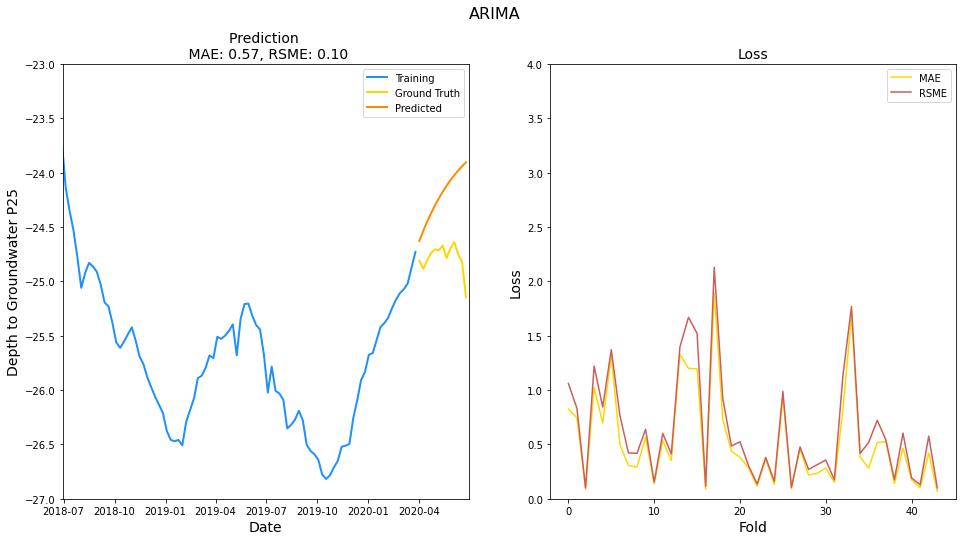

In [57]:
from statsmodels.tsa.arima.model import ARIMA

score_mae = []
score_rsme = []

for fold, valid_quarter_id in enumerate(range(2, N_SPLITS)):
    # Get indices for this fold
    train_index = df[df.quarter_idx < valid_quarter_id].index
    valid_index = df[df.quarter_idx == valid_quarter_id].index

    # Prepare training and validation data for this fold
    y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]
    
    # Fit model with Vector ARIMA
    model = ARIMA(y_train, order=(1,1,1))
    model_fit = model.fit()
    
    # Prediction with ARIMA
    y_valid_pred = model_fit.predict(valid_index[0], valid_index[-1])

    # Calcuate metrics
    score_mae.append(mean_absolute_error(y_valid, y_valid_pred))
    score_rsme.append(math.sqrt(mean_squared_error(y_valid, y_valid_pred)))


# Fit model with ARIMA
model = ARIMA(y, order=(1,1,1))
model_fit = model.fit()

# Prediction with ARIMA
y_pred = model_fit.predict(y.index[-1]+1, y.index[-1] + len(y_test)).reset_index(drop=True)
plot_approach_evaluation(y_pred, score_mae, score_rsme, 'ARIMA')

### Multivariate Model

#### Vector Auto Regression (VAR)

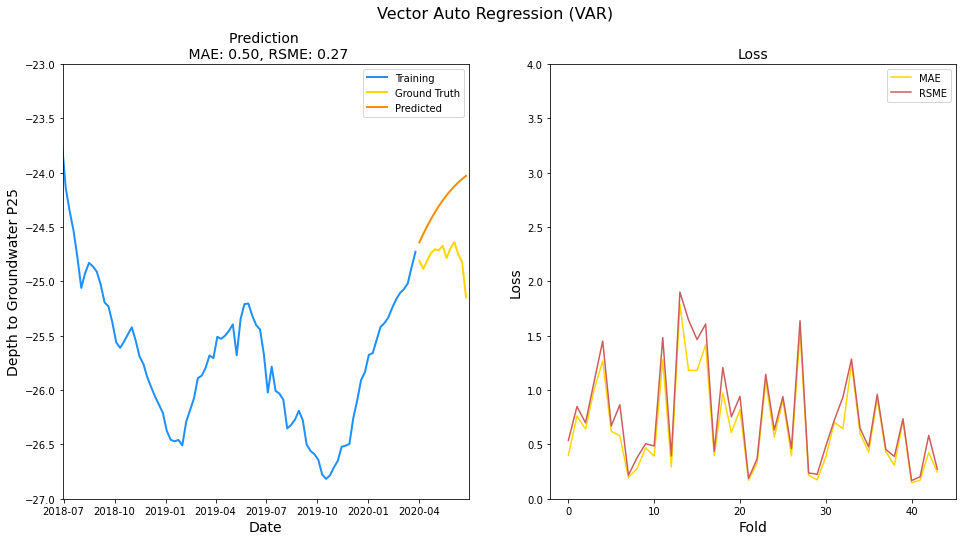

In [59]:
from statsmodels.tsa.api import VAR

score_mae = []
score_rsme = []

features = ['Temperature', 'Drainage_Volume', 'River_Hydrometry','Rainfall' ]
for fold, valid_quarter_id in enumerate(range(2, N_SPLITS)):
    # Get indices for this fold
    train_index = df[df.quarter_idx < valid_quarter_id].index
    valid_index = df[df.quarter_idx == valid_quarter_id].index
    
    # Prepare training and validation data for this fold
    X_train, X_valid = X.iloc[train_index][features], X.iloc[valid_index][features]
    y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]
    
    # Fit model with Vector Auto Regression (VAR)
    model = VAR(pd.concat([y_train, X_train], axis=1))
    model_fit = model.fit()
    
    # Prediction with Vector Auto Regression (VAR)
    y_valid_pred = model_fit.forecast(model_fit.y, steps=len(X_valid))
    y_valid_pred = pd.Series(y_valid_pred[:, 0])
    
    # Calcuate metrics
    score_mae.append(mean_absolute_error(y_valid, y_valid_pred))
    score_rsme.append(math.sqrt(mean_squared_error(y_valid, y_valid_pred)))

# Fit model with Vector Auto Regression (VAR)
model = VAR(pd.concat([y, X[features]], axis=1))
model_fit = model.fit()

# Prediction with Vector Auto Regression (VAR)
y_pred = model_fit.forecast(model_fit.y, steps=len(X_valid))
y_pred = pd.Series(y_pred[:, 0])

plot_approach_evaluation(y_pred, score_mae, score_rsme, 'Vector Auto Regression (VAR)')
    